## This starts the same as the time-domain version, but uses a computationally faster frequency domain approach. This is not reflected in our paper, and is included here in case it is helpful.

In [144]:
# Python 3.7

import sys
sys.path.append('../GI1_v0.2.1')
sys.path.append('../GI1_v0.2.1/PLOT/')
sys.path.append('../GI1_additions')


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import green as g
import source as s
import processing as proc
import parameters
import time
import random
from correlation_random import *
from correlation_function import *
from correlation_field import *
from kernels import *
from adsrc import *
from earthquakes import *

# The following are newly added, as compared to the original GI code.
from generate_random_signals import *
from specshift import *

%matplotlib inline

In [145]:
mpl.rcParams['figure.figsize'] = [20, 10]

In [146]:
## Check the station and noise-source geometry
# S,indeces=s.space_distribution(plot=1)

In [147]:
use_saved_data = True

#####################################################
if(use_saved_data is False):
    
    # Check the station and noise-source geometry
    S,indeces=s.space_distribution(plot=1)


    # Re-create the synthetic data.
    ut,traw,cct,t,ccf,f = generate_random_signals(verbose=False,plot=True,save=True,return_cc=True)
#####################################################
else:
    # Alternatively, just load from file
    p=parameters.Parameters()

    # Load "traw" of raw timeseries
    filename = './OUTPUT/raw_synthetics/traw.npy'
    traw = np.load(filename)
    
    # Load raw timeseries
    for i in range(p.Nreceivers):
        filename = './OUTPUT/raw_synthetics/syn_{0}.npy'.format(i)
        if(i==0): # first one, load to get size.
            tmp = np.load(filename)
            [nsamp,nwindows] = np.shape(tmp)
            ut = np.zeros([nsamp,nwindows,p.Nreceivers])
            ut[:,:,i] = tmp
        else:
            ut[:,:,i] = np.load(filename)
    
#     # Load "t" of correlations functions
#     filename = './OUTPUT/correlations_measured/t.npy'
#     tt_corr = np.load(filename)
#     nt = np.size(tt_corr)

#     # Load correlation functions
#     cct = np.zeros([nt,p.Nwindows,p.Nreceivers**2])
#     counter = 0
#     for i in range(p.Nreceivers):
#         for j in range(p.Nreceivers):        
#             filename = "./OUTPUT/correlations_measured/cct_proc_{}_{}.npy".format(i,j)
#             this_corr = np.load(filename)

#             cct[:,:,counter] = this_corr
#             counter += 1
#####################################################


## A quick back-of-the-envelope check of our array dimensions.
### The bandpass filter of our data should be comparable to the wavelengths/frequencies resolveable by the array aperature and station-spacing.

### In general, beamforming can be used on data that with shorter or longer periods than described here. In the case of shorter periods (high frequency), expect aliasing. In the case of longer periods (low frequency), expect a large "blob" or poor resolution.

### The array-response function (not shown here) can be useful to characterize an array, and potentially even deconvolved from the resulting image.

In [148]:

xx = p.x/1000
yy = p.y/1000
dis=[]
for i in range(p.Nreceivers):
    for j in range(p.Nreceivers):
        if(i==j):
            continue
        dis.append( np.sqrt( (xx[i]-xx[j])**2 + (yy[i]-yy[j])**2 ))
print("Average distance = {0:.2f}km".format(np.mean(dis)))
print("At 3km/s, average period for array = {0:.2f}sec".format(np.mean(dis)/3))
print("")

print("Min distance (inter-station) = {0:.2f}km".format(np.min(dis)))
print("At 3km/s, shortest period = {0:.2f}sec".format(np.min(dis)/3))
print("")


print("Max distance (aperture) = {0:.2f}km".format(np.max(dis)))
print("At 3km/s, longest period = {0:.2f}sec".format(np.max(dis)/3))
print("")


print("Signals bandpassed from {0:.2f} to {1:.2f} Hz, {2:.2f} to {3:.2f} seconds".format(p.bp_fmin,p.bp_fmax,1/p.bp_fmax,1/p.bp_fmin))

Average distance = 6.06km
At 3km/s, average period for array = 2.02sec

Min distance (inter-station) = 1.95km
At 3km/s, shortest period = 0.65sec

Max distance (aperture) = 12.33km
At 3km/s, longest period = 4.11sec

Signals bandpassed from 0.30 to 5.70 Hz, 0.18 to 3.33 seconds


## Frequency Domain!

32768


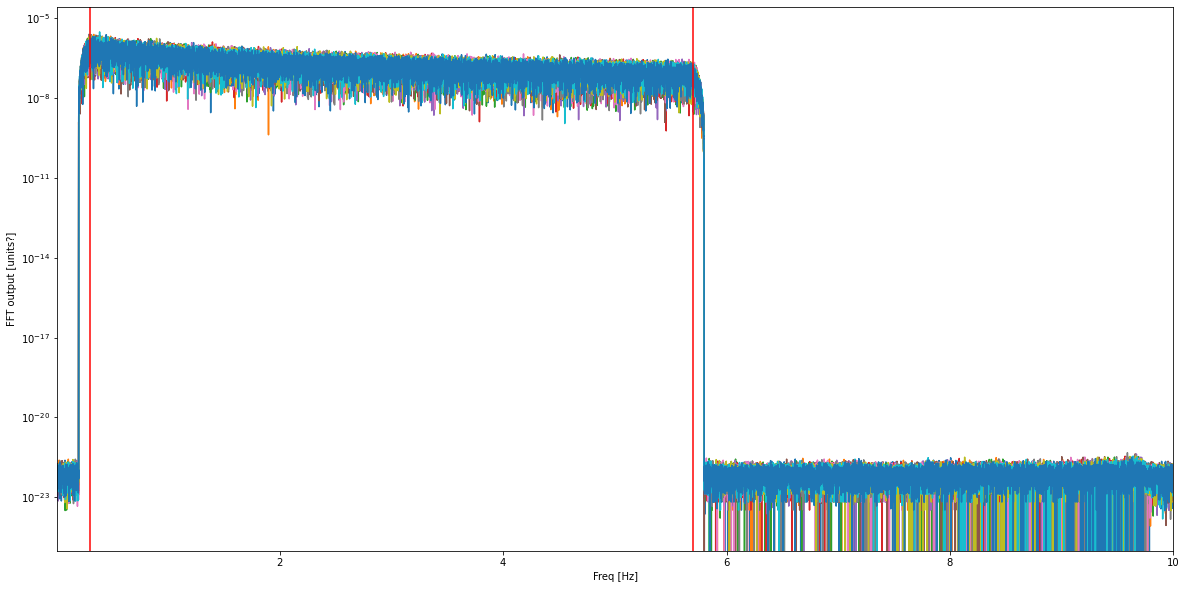

In [153]:
iwin=0
data=ut[:,iwin,:]
npts = np.shape(data)[0]
nsta = np.shape(data)[1]
dt = traw[1]-traw[0]        # or use p.dt

# Define our frequencies
nfft = (2.0**np.ceil(np.log2(npts))).astype(int)
print(nfft)
df=1.0/(2.0*nfft*dt)
# "xf" will be our x-axis; the frequencies that result from our fft()
xf = np.linspace(0.0, 1.0/(2.0*dt), np.int((nfft/2)+1))


# df=1.0/(nfft*dt)
# xf = np.linspace(0.0, 1.0/(dt), np.int((nfft/2)+1))


spectra = np.zeros([np.size(xf),nsta],dtype='complex')
for ii in range(nsta):
     spectra[:,ii] = np.fft.rfft(data[:,ii],n=nfft)
# Our input timeseries is real, so we use rfft().
# rfft() knows that the output is symmetric, and so only returns ~1/2 of the full "nfft" we gave it

# Plot the spectra, just to make sure we're on the right track
plt.semilogy(xf, np.abs(spectra))
plt.xlim([0.01,10])
plt.ylim([10^-9,10^-3])
plt.xlabel('Freq [Hz]')
plt.ylabel('FFT output [units?]')
plt.axvline(p.bp_fmin,color='r')
plt.axvline(p.bp_fmax,color='r')
plt.show()


## Beamform 

In [154]:
# Here we take a single frequency, and apply a phase shift
# We will average the results of several frequencies
# Make a linear spacing of frequencies. One might use periods, logspacing, etc.
num_freqs = 1000
f_min = 1  #or p.bp_fmin
f_max = 5  #or p.bp_fmax

# num_freqs = 1
# f_min = 1
# f_max = 2
target_freqs = np.linspace(f_min,f_max,num_freqs)


# Define a grid of slownesses to test
# max-slowness:
sl=.75 # second/km

# number of pixes in x and y
nux = 101
nuy = 101
ux = np.linspace(-sl,sl,nux)
uy = np.linspace(-sl,sl,nuy)
dux=ux[1]-ux[0]
duy=uy[1]-uy[0]

# Station locations (we'll convert to km here)
xx = p.x/1000
yy = p.y/1000


# To speed things up, we precompute a library of timeshifts,
#  so we don't have to do it for each loop of frequency
tlib=np.zeros([nsta,nux,nuy],dtype=float)
for ix in range(0,nux):
        for iy in range(0,nux):
            tlib[:,ix,iy] = xx*ux[ix] + yy*uy[iy]
# In this case, we assume station locations xx and yy are already relative to some convenient midpoint
# Rather than shift one station to a single other station, we'll shift *all* stations back to that midpoint

# Define the index of actual noise source, for visual verification
# (as defined in source.py)
expected_slowness = 1/3.0
sx = expected_slowness*np.sqrt(2)/2
sy = expected_slowness*np.sqrt(2)/2
ix0=(np.abs(ux-sx)).argmin()
iy0=(np.abs(uy-sy)).argmin()

Pfreq=np.zeros([num_freqs,nux,nuy],dtype=complex)

counter_grid = 0
print("starting {0} frequencies".format(num_freqs))

for ii in range(num_freqs):
    if(ii % 100 == 0):
        print(ii)
    #target_f = 1/target_periods[ii]
    target_f = target_freqs[ii]
    idf = (np.abs(xf - target_f)).argmin()

    # Construct a matrix of each station-station correlation *before* any phase shifts
    Rxx=np.zeros([nsta,nsta],dtype=complex)
    for i1 in range(0,nsta):
        for i2 in range(0,nsta):
            Rxx[i1,i2] = np.conj(spectra[idf,i1]) * spectra[idf,i2]

    for ix in range(0,nux):
            for iy in range(0,nux):
                    timeshifts = tlib[:,ix,iy]

                    a = np.exp(-1j*2*np.pi*target_f*timeshifts)
                    aconj = np.conj(a)
                    # "a" is a "steering vector." It contains info on all the phase delays needed to 
                    #  push our stations to the middle point.
                    #
                    # Since each element of Rxx contains cross-spectra of two stations, we need two timeshifts
                    #  to push both to the centerpoint. This can also be seen as projecting Rxx onto a new basis.
                    Pfreq[ii,ix,iy]=np.dot(np.dot(aconj,Rxx),a)


print(np.shape(Psum))
# np.save('1_P', P)


starting 1000 frequencies
0
100
200
300
400
500
600
700
800
900
(101, 101)


In [155]:
# Note that some users will normalize the beamform heatmap at each freq before summing
# This is similar to using spectral whitening in pre-processing - each frequency will contribute an equal amount

# Also note that there may be different conventions about whether the diagonals should be used (autocorrelation)
                    
## Normalize the intensity of each period
# Pfreq_norm=np.zeros([num_freqs,nux,nuy],dtype=complex)
# for ii in range(num_freqs):
#     Pfreq_norm[ii,:,:] = Pfreq[ii,:,:] / np.sum(np.abs(Pfreq[ii,:,:]))
# Psum = np.sum(Pfreq_norm,axis=0)
    
Psum = np.sum(Pfreq,axis=0)


## Plotting

### First, on a square grid

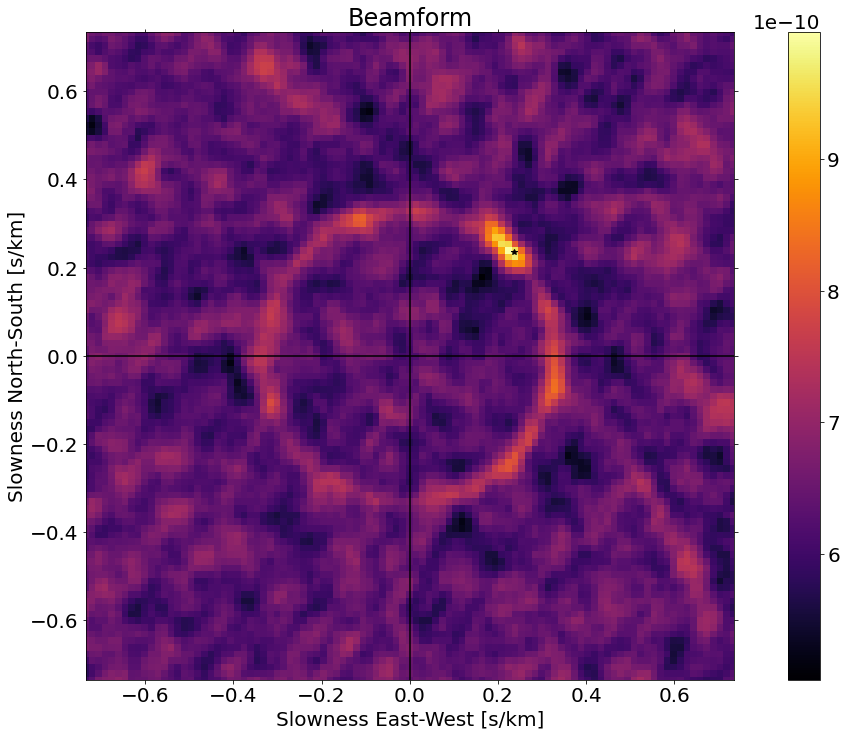

In [156]:
mpl.rc('font', **{'size':20})

def plot_beam(P, title="Beamform",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.6,0.6])  #x0,y0,dx,dy
    cmap = plt.get_cmap('inferno')
    i = plt.pcolor(ux-dux/2,uy-duy/2,np.real(P.T),cmap=cmap,rasterized=True)#,vmin=-4,vmax=4)
    if(cmax==0):
        cmax=np.max(np.abs(P))
    cmin=np.min(P)
    plt.clim(cmin, cmax)
    
    plt.axis('equal')
    plt.axis('tight')
    plt.xlim(min(ux)+dux,max(ux)-dux)
    plt.ylim(min(uy)+duy,max(uy)-duy)
    plt.xlabel('Slowness East-West [s/km]')
    plt.ylabel('Slowness North-South [s/km]')
    ax.tick_params(top=True,right=True)
    plt.plot(sx,sy,'k*')
    plt.plot([np.min(ux), np.max(ux)],[0,0],'k')
    plt.plot([0,0],[np.min(uy), np.max(uy)],'k')
    plt.title(title)
    colorbar_ax = fig.add_axes([0.75, 0.1, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()

# plot_beam(np.abs(Pfreq[10,:,:]), title="Beamform", 
#           save=False, savename="1_freqdomain_beamform_square")

plot_beam(np.abs(Psum), title="Beamform", 
          save=False, savename="1_freqdomain_beamform_square")

### Now, transform to polar axis and plot on a circular grid.
### We find this is somewhat more intuitive for readers; it is easier to understand that this is pointing out towards different directions when it looks like a compass. 
### Note - a better algorithm might define the slowness domain on polar coordinates from the very beginning. This would require reorganizing the for-loops in the algorithm above, to gridsearch through values of theta and r. 

In [157]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

UX, UY = np.meshgrid(ux, uy)
UR = np.zeros_like(UX)
UT = np.zeros_like(UY)
for iux in range(nux):
    for iuy in range(nuy):
#         UR[iux, iuy], UT[iux, iuy] = cart2pol(UX[iux, iuy], UY[iux, iuy])
        UR[iux, iuy], UT[iux, iuy] = cart2pol(UX[iux, iuy]-dux/2, UY[iux, iuy]-duy/2)
        
SR, ST = cart2pol(sx, sy)


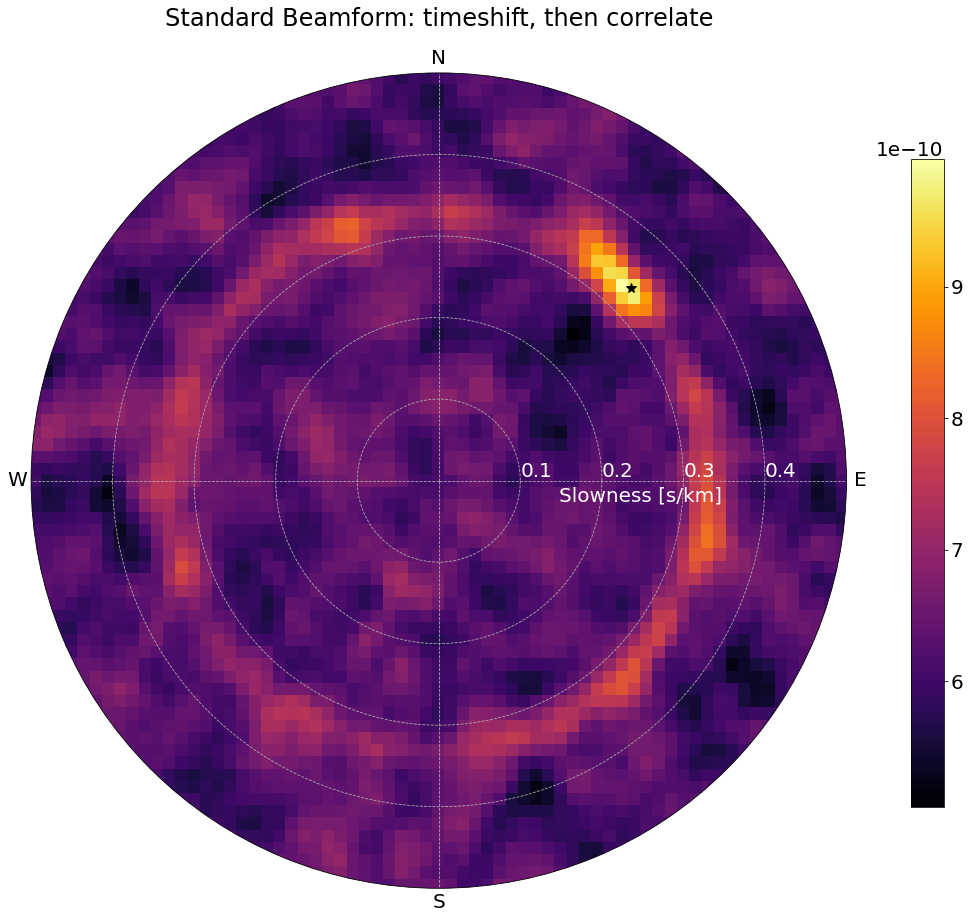

In [159]:
mpl.rc('font', **{'size':20})
    
def plot_beam_polar(P, title="Beamform",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar = True)
    cmap = plt.get_cmap('inferno')
    i = plt.pcolor(2*np.pi-UT[::1]+np.pi/2, UR[::1], np.real(P[::1]), cmap=cmap, rasterized=True)
    
    if(cmax==0):
        cmax=np.max(np.abs(P))
    cmin=np.min(P)
    plt.clim(cmin, cmax)
    
    # set title, labels, etc
    plt.title(title)
    
    ax.set_xticks(np.arange(0, 2.0*np.pi, np.pi/2.0))
    ax.set_xticklabels(["E", "N", "W", "S"])
    ax.tick_params(axis='x', colors='black', grid_linestyle='--')
    
    ax.set_ylim(0,0.5)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4])
    ax.tick_params(axis='y', colors='white', grid_linestyle='--')
    ax.text(np.radians(-10), 0.15, 'Slowness [s/km]', rotation=0, color="white")
    ax.set_rlabel_position(0)
    ax.grid(True)
    
    # plot expected blob
    plt.plot(ST, SR, 'k*', markersize=11)

    # colorbar
    colorbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)
    
    # save figure
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()


plot_beam_polar(np.abs(Psum),title="Standard Beamform: timeshift, then correlate", save=False, savename="1_freqdomain_beamform_polar.pdf")
